# Build mutliclass classification models that use PCA components

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import poisson
from sklearn.svm import SVC 
from sklearn.metrics import accuracy_score, classification_report
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
xgb.set_config(verbosity=0)
from sklearn.feature_selection import RFECV
import random
from scipy import stats
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn import svm, datasets
from sklearn.metrics import log_loss

## Preprocessing

In [28]:
df = pd.read_csv("dataset\CSF_Proteomics_ADNI.csv")

#replace categorical feature with index labeling
df['binary_class'].replace({'stable':0,'decliner':1},inplace=True)
df['three_class'].replace({'slowDecline':0,'rapidDecline':1,'stable':2},inplace=True)

#differentiate other categorical features from the numerical ones
pheno = df.loc[:,'RID':'VISCODE']
data = df.loc[:,'A1AT.AVLTIDEK':'VTDB.VPTADLEDVLPLAEDITNILSK']

## Normalization

#normally test function -> check if each column is normally distr
def norm_test(data):
    alpha = 1e-3
    k2, p = stats.normaltest(data)
    count=0
    for i in p:
        if i > alpha:  # null hypothesis: x comes from a normal distribution
            count+=1
    print('There are ',count,'normally distributed features out of',data.shape[1])

#QUANTILE NORMALIZATION
def quantile_normalize(df):
    df_sorted = pd.DataFrame(np.sort(df.values,axis=0),index=df.index,columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn =df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return df_qn

# compute quantile normalized data
df_qn=quantile_normalize(data)
data = df_qn

#Scale the data to the range between 0 and 1 before using PCA
scaler = MinMaxScaler()
data_rescaled = scaler.fit_transform(data)

## Split dataset
X = data_rescaled
y = df["three_class"]

## Test models using with PCA as feature selection

In [8]:
# Make an instance of the model keeping 95% of the features variance
pca = PCA(0.8)
# pca = PCA(n_components=100)

principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)
print('Note that we now have',principalDf.shape[1],'columns instead of',X.shape[1])

X_train_20, X_test_20, y_train_20, y_test_20 = train_test_split(principalDf, y, test_size = 0.20, random_state = 97, stratify = y)
X_train_40, X_test_40, y_train_40, y_test_40 = train_test_split(principalDf, y, test_size = 0.40, random_state = 97, stratify = y)

Note that we now have 13 columns instead of 320


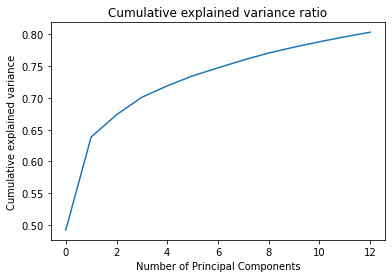

In [9]:
PC_values = np.arange(pca.n_components_)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative explained variance ratio')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative explained variance');

### Single xgb classifier

In [10]:
def XGB_class(X_train, X_test, y_train, y_test,learning_rate, n_estimators, max_depth,min_child_weight, gamma, subsample, colsample_bytree, simple):
    
    if simple:
        clf = xgb.XGBClassifier(seed = 24, use_label_encoder =False,objective='multi:softproba')
    else:
        clf = xgb.XGBClassifier(learning_rate = learning_rate, n_estimators = int(n_estimators), max_depth = int(max_depth), 
                                min_child_weight = min_child_weight, gamma = gamma, subsample = subsample, 
                                colsample_bytree = colsample_bytree, seed = 24,eval_metric='mlogloss',use_label_encoder =False,objective='multi:softproba')

    clf.fit(X_train, y_train)
    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))
    
    y_test = label_binarize(y_test, classes=np.arange(3))
    y_predicted = label_binarize(y_predicted, classes=np.arange(3))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    print("AUC =",roc_auc)
    
    return clf.predict_proba(X_test)

In [14]:
print('Using 20% testing subset:')
sXGBc_y_predicted_20 = XGB_class(X_train_20,X_test_20,y_train_20,y_test_20,0,0,0,0,0,0,0,simple=True)
print('Using 40% testing subset:')
sXGBc_y_predicted_40 = XGB_class(X_train_40,X_test_40,y_train_40,y_test_40,0,0,0,0,0,0,0,simple=True)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.50      0.33      0.40         9
           1       0.64      0.90      0.75        10
           2       0.71      0.62      0.67         8

    accuracy                           0.63        27
   macro avg       0.62      0.62      0.61        27
weighted avg       0.62      0.63      0.61        27

Accuracy: 0.6296296296296297
MCC = 0.44883281169845735
AUC = {0: 0.5833333333333334, 1: 0.8029411764705882, 2: 0.7598684210526316}
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.44      0.37      0.40        19
           1       0.40      0.50      0.44        20
           2       0.46      0.40      0.43        15

    accuracy                           0.43        54
   macro avg       0.43      0.42      0.42        54
weighted avg       0.43      0.43      0.42        54

Accuracy: 0.42592592592592593
MCC = 0.12804770511154298

### SVM

In [15]:
def SVM_class(X_train,X_test,y_train,y_test):
    clf = svm.SVC(kernel='poly',probability=True).fit(X_train, y_train)

    y_predicted = clf.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [18]:
print('Using 20% testing subset:')
SVM_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% testing subset:')
SVM_class(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.29      0.22      0.25         9
           1       0.41      0.70      0.52        10
           2       0.67      0.25      0.36         8

    accuracy                           0.41        27
   macro avg       0.45      0.39      0.38        27
weighted avg       0.45      0.41      0.38        27

Accuracy: 0.4074074074074074
MCC = 0.09302627456302742
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.40      0.11      0.17        19
           1       0.41      0.95      0.58        20
           2       0.67      0.13      0.22        15

    accuracy                           0.43        54
   macro avg       0.49      0.40      0.32        54
weighted avg       0.48      0.43      0.33        54

Accuracy: 0.42592592592592593
MCC = 0.14968502308663567


### Single Random Forest classifier

In [20]:
def SRF_class(X_train,X_test,y_train,y_test):
    model = RandomForestClassifier().fit(X_train,y_train)
    y_predicted = model.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [21]:
print('Using 20% testing subset:')
SRF_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% testing subset:')
SRF_class(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.25      0.22      0.24         9
           1       0.46      0.60      0.52        10
           2       0.67      0.50      0.57         8

    accuracy                           0.44        27
   macro avg       0.46      0.44      0.44        27
weighted avg       0.45      0.44      0.44        27

Accuracy: 0.4444444444444444
MCC = 0.1568303541131437
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.50      0.37      0.42        19
           1       0.50      0.80      0.62        20
           2       0.50      0.27      0.35        15

    accuracy                           0.50        54
   macro avg       0.50      0.48      0.46        54
weighted avg       0.50      0.50      0.47        54

Accuracy: 0.5
MCC = 0.243413698441244


### Logistic Regression

In [22]:
def LR_class(X_train,X_test,y_train,y_test):
    model = LogisticRegression(multi_class='multinomial', solver='lbfgs').fit(X_train,y_train)
    y_predicted = model.predict(X_test)

    print(classification_report(y_test, y_predicted))
    print("Accuracy:", accuracy_score(y_test, y_predicted))
    print("MCC =",matthews_corrcoef(y_test, y_predicted))

In [23]:
print('Using 20% testing subset:')
LR_class(X_train_20,X_test_20,y_train_20,y_test_20)
print('Using 40% testing subset:')
LR_class(X_train_40,X_test_40,y_train_40,y_test_40)

Using 20% testing subset:
              precision    recall  f1-score   support

           0       0.33      0.22      0.27         9
           1       0.57      0.80      0.67        10
           2       0.57      0.50      0.53         8

    accuracy                           0.52        27
   macro avg       0.49      0.51      0.49        27
weighted avg       0.49      0.52      0.49        27

Accuracy: 0.5185185185185185
MCC = 0.2748832530976198
Using 40% testing subset:
              precision    recall  f1-score   support

           0       0.50      0.32      0.39        19
           1       0.55      0.90      0.68        20
           2       0.56      0.33      0.42        15

    accuracy                           0.54        54
   macro avg       0.53      0.52      0.49        54
weighted avg       0.53      0.54      0.50        54

Accuracy: 0.5370370370370371
MCC = 0.3088089787998994


### Test which PCA variance is the best for XGBoost classifier model

In [64]:
variances = np.arange(0.5, 0.99, 0.01).tolist()
nbr_tests = 10

# Creates a list containing 5 lists, each of 8 items, all set to 0
w, h = nbr_tests, len(variances)
perf = [[0 for x in range(w)] for y in range(h)] 

for i in range(nbr_tests):
    for j in range(len(variances)):
        pca = PCA(variances[j])

        principalComponents = pca.fit_transform(X)
        principalDf = pd.DataFrame(data = principalComponents)

        X_train, X_test, y_train, y_test = train_test_split(principalDf, y, test_size = 0.20)

        clf = xgb.XGBClassifier(random_state = random.randint(0,nbr_tests),use_label_encoder =False,objective='multi:softproba')
        clf.fit(X_train, y_train)
        y_predicted = clf.predict_proba(X_test)

        log_l = log_loss(y_test, y_predicted) 
        perf[j][i] = log_l

avg_perf = []
for i in range(len(perf)):
    avg_perf.append(sum(perf[i]) / len(perf[i]))

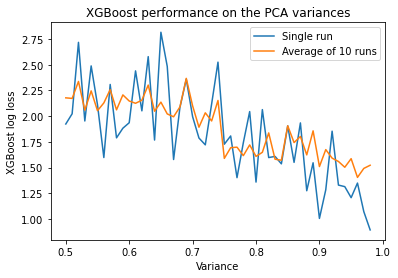

So best variance with the XGBoost Classifier model is 0.96


In [67]:
plt.plot(variances, [item[0] for item in perf])
plt.plot(variances, avg_perf)
plt.xlabel('Variance') 
plt.ylabel('XGBoost log loss') 
plt.title("XGBoost performance on the PCA variances")
plt.legend(['Single run',('Average of '+str(nbr_tests)+' runs')])
plt.show()
print("So best variance with the XGBoost Classifier model is 0.96")